<a href="https://www.kaggle.com/code/onedatareader/fake-news-detection?scriptVersionId=115546714" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [2]:
import numpy as np 
import pandas as pd 
import os
import spacy
import matplotlib.pyplot as plt 
import seaborn as sns 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px
from plotly.offline import init_notebook_mode
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tqdm import tqdm
nltk.download('omw-1.4')
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)


tqdm.pandas()
spacy_eng = spacy.load("en_core_web_sm")
nltk.download('stopwords')
lemm = WordNetLemmatizer()
init_notebook_mode(connected=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 18

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
headlines_v1 = pd.read_json('../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', lines=True)
headlines_v2 = pd.read_json('../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json', lines=True)

In [4]:
headlines_v1 = headlines_v1[['headline','is_sarcastic']]
headlines_v2 = headlines_v2[['headline','is_sarcastic']]

headlines = pd.concat([headlines_v1,headlines_v2])
headlines.reset_index(drop=True, inplace=True)

In [5]:
headlines.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
headlines.shape

(55328, 2)

In [7]:
headlines.info()

# We can see that there are no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55328 entries, 0 to 55327
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      55328 non-null  object
 1   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 864.6+ KB


In [8]:
px.bar(headlines.groupby('is_sarcastic').count().reset_index(), 
       x='headline',
       y = ['Real','Sarcastic'],
       title='Counts for real and fake news headlines',
       labels={'headline':'Number of headlines', 'y':'News Type'},
       color = 'headline'
      )

## Deep diving into preprocessing

In [9]:
# Let's check the sentence length 
headlines['sen_len_before_pre'] = headlines['headline'].apply(lambda x: len(x.split()))
headlines

,headline,is_sarcastic,sen_len_before_pre
0,former versace store clerk sues over secret 'b...,0,12
1,the 'roseanne' revival catches up to our thorn...,0,14
2,mom starting to fear son's web series closest ...,1,14
3,"boehner just wants wife to listen, not come up...",1,13
4,j.k. rowling wishes snape happy birthday in th...,0,11
...,...,...,...
55323,jews to celebrate rosh hashasha or something,1,7
55324,internal affairs investigator disappointed con...,1,13
55325,the most beautiful acceptance speech this week...,0,12
55326,mars probe destroyed by orbiting spielberg-gat...,1,8


In [10]:
# Data cleaning - Stop words removal, lemmatization, special characters removal

stop_words = stopwords.words('english')
stop_words.remove('not')

def clean_text(sentence):
    
    headline = re.sub('\s+\n+', ' ', sentence)
    headline = re.sub('[^a-zA-Z0-9]', ' ', sentence)
    headline = headline.lower()
    headline = headline.split()
    
    headline = [lemm.lemmatize(word, "v") for word in headline if not word in stop_words]
    headline = ' '.join(headline)
    
    return headline

In [11]:
headlines['clean_headline'] = headlines['headline'].apply(clean_text)

In [12]:
headlines.head()

,headline,is_sarcastic,sen_len_before_pre,clean_headline
0,former versace store clerk sues over secret 'b...,0,12,former versace store clerk sue secret black co...
1,the 'roseanne' revival catches up to our thorn...,0,14,roseanne revival catch thorny political mood b...
2,mom starting to fear son's web series closest ...,1,14,mom start fear son web series closest thing gr...
3,"boehner just wants wife to listen, not come up...",1,13,boehner want wife listen not come alternative ...
4,j.k. rowling wishes snape happy birthday in th...,0,11,j k rowling wish snape happy birthday magical way


In [13]:
headlines['sen_len_after_pre'] = headlines['clean_headline'].apply(lambda x: len(x.split()))
headlines

,headline,is_sarcastic,sen_len_before_pre,clean_headline,sen_len_after_pre
0,former versace store clerk sues over secret 'b...,0,12,former versace store clerk sue secret black co...,10
1,the 'roseanne' revival catches up to our thorn...,0,14,roseanne revival catch thorny political mood b...,8
2,mom starting to fear son's web series closest ...,1,14,mom start fear son web series closest thing gr...,9
3,"boehner just wants wife to listen, not come up...",1,13,boehner want wife listen not come alternative ...,10
4,j.k. rowling wishes snape happy birthday in th...,0,11,j k rowling wish snape happy birthday magical way,9
...,...,...,...,...,...
55323,jews to celebrate rosh hashasha or something,1,7,jews celebrate rosh hashasha something,5
55324,internal affairs investigator disappointed con...,1,13,internal affairs investigator disappoint consp...,8
55325,the most beautiful acceptance speech this week...,0,12,beautiful acceptance speech week come queer ko...,7
55326,mars probe destroyed by orbiting spielberg-gat...,1,8,mar probe destroy orbit spielberg gate space p...,8


In [14]:
# Checking the Named-Entity relationship of sentences to get a detailed view of the content

def entity_detection(x):
    entity = []
    text = spacy_eng(x)
    for word in text.ents:
        entity.append(word.label_)
    return ",".join(entity)

# df.apply(func)
#df.parallel_apply(func)
headlines['entity'] = headlines['clean_headline'].parallel_apply(entity_detection)

In [15]:
headlines

,headline,is_sarcastic,sen_len_before_pre,clean_headline,sen_len_after_pre,entity
0,former versace store clerk sues over secret 'b...,0,12,former versace store clerk sue secret black co...,10,
1,the 'roseanne' revival catches up to our thorn...,0,14,roseanne revival catch thorny political mood b...,8,PERSON
2,mom starting to fear son's web series closest ...,1,14,mom start fear son web series closest thing gr...,9,
3,"boehner just wants wife to listen, not come up...",1,13,boehner want wife listen not come alternative ...,10,
4,j.k. rowling wishes snape happy birthday in th...,0,11,j k rowling wish snape happy birthday magical way,9,PERSON
...,...,...,...,...,...,...
55323,jews to celebrate rosh hashasha or something,1,7,jews celebrate rosh hashasha something,5,
55324,internal affairs investigator disappointed con...,1,13,internal affairs investigator disappoint consp...,8,ORG
55325,the most beautiful acceptance speech this week...,0,12,beautiful acceptance speech week come queer ko...,7,"DATE,NORP"
55326,mars probe destroyed by orbiting spielberg-gat...,1,8,mar probe destroy orbit spielberg gate space p...,8,FAC


In [16]:
# Sentence length analysis - Looking for outlier length 
px.histogram(headlines, 
             x="sen_len_after_pre",
             height=800,
             color='is_sarcastic', 
             title="Headlines Length Distribution", 
             marginal="box",
             labels={'sen_len_after_pre':'Sentence Length'},
            )

# We see that there are some samples showing outlier nature

In [17]:
headlines[headlines['sen_len_after_pre']> 100]['clean_headline'].iloc[0]

'hot wheel rank number one toy roll ramp knock dominoes send marble funnel drop onto teeter totter yank string cause pulley system raise wooden block propel series twine rollers unwind spring launch tennis ball across room inch tire slope hit power switch activate table fan blow toy ship nail attach across kiddie pool pop water balloon fill cup weigh lever force basketball track nudge broomstick axis rotate allow golf ball roll sideways coffee mug tumble row hardcover book handle catch hook attach lever cause wooden mallet slam serve spoon catapult small ball cup attach ribbon lazy susan spin push battery incline plane tip salt shaker season omelet'

In [18]:
headlines.drop(headlines[headlines['sen_len_after_pre'] > 100].index, inplace = True)
headlines.reset_index(inplace=True, drop=True)

In [19]:
headlines.head()

,headline,is_sarcastic,sen_len_before_pre,clean_headline,sen_len_after_pre,entity
0,former versace store clerk sues over secret 'b...,0,12,former versace store clerk sue secret black co...,10,
1,the 'roseanne' revival catches up to our thorn...,0,14,roseanne revival catch thorny political mood b...,8,PERSON
2,mom starting to fear son's web series closest ...,1,14,mom start fear son web series closest thing gr...,9,
3,"boehner just wants wife to listen, not come up...",1,13,boehner want wife listen not come alternative ...,10,
4,j.k. rowling wishes snape happy birthday in th...,0,11,j k rowling wish snape happy birthday magical way,9,PERSON


In [20]:
px.histogram(headlines, 
             x="sen_len_after_pre",
             height=800,
             color='is_sarcastic', 
             title="Headlines Length Distribution after outlier removal", 
             marginal="box",
             labels={'sen_len_after_pre':'Sentence Length'},
            )


## Word Clouds

In [21]:
sarcastic = headlines[headlines['is_sarcastic']==1]['clean_headline'].tolist()
real = headlines[headlines['is_sarcastic']==0]['clean_headline'].tolist()

### Top 100 Sarcastic words

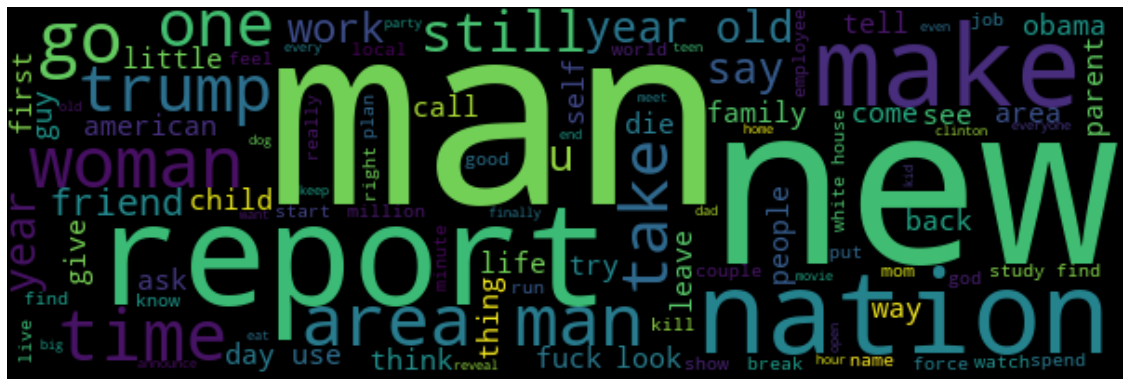

In [22]:
wordcloud = WordCloud(max_words=100, width=600, background_color='black').generate(" ".join(sarcastic))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Top 100 real words

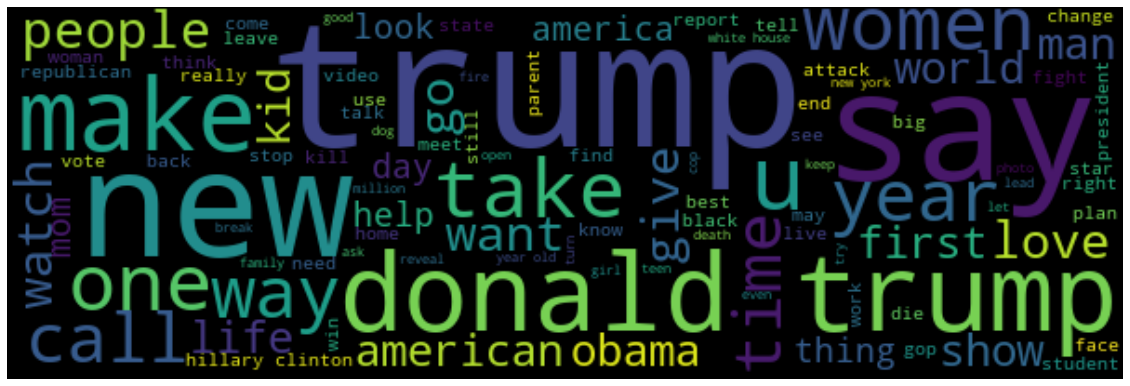

In [23]:
wordcloud = WordCloud(max_words=100, width=600, background_color='black').generate(" ".join(real))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Model Building